In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models import TfidfModel

# spacy
import spacy

# vis
import pyLDAvis
import pyLDAvis.gensim

In [11]:
# Load data
data = pd.read_json("dataset_1M.json", lines=True)

In [3]:
# View some samples
data.head()

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,4,False,"05 1, 2015",A8WEXFRWX1ZHH,0209688726,{'Color:': ' AC'},Goldengate,"After I wrote the below review, the manufactur...",Works well if you place phone in horizontally ...,1430438400,None,None
1,1,True,"04 19, 2018",ABCA1A8E4DGV1,0209688726,{'Color:': ' Blue'},noe,It sucks barely picks up anything definitely n...,sucks,1524096000,None,None
2,1,True,"04 16, 2018",A1NX8HM89FRQ32,0209688726,{'Color:': ' Black'},Eduard,"Well to write a short one, it blew 2 fuses of ...",Defective,1523836800,None,None
3,3,True,"04 13, 2018",A1X77G023NY0KY,0209688726,{'Color:': ' CA'},Lauren,I have absolutely no memory of buying this but...,Looks cool! Probably works,1523577600,None,None
4,5,True,"04 8, 2018",A3GK37JO2MGW6Q,0209688726,{'Color:': ' Black'},danny,it ok it does it job,Five Stars,1523145600,None,None


In [4]:
# Calculate counts for each column
data.count()

overall           1000000
verified          1000000
reviewTime        1000000
reviewerID        1000000
asin              1000000
style              358331
reviewerName       999917
reviewText         999636
summary            999862
unixReviewTime    1000000
vote               121947
image               16345
dtype: int64

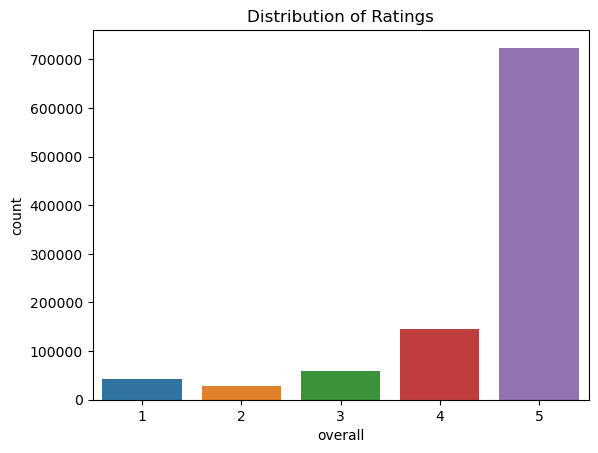

In [5]:
# Plot frequencies of ratings
sns.countplot(x='overall', data=data)
plt.title('Distribution of Ratings')
plt.show()

In [12]:
# Replace Nones with empty strings
data.fillna("", inplace=True)

In [7]:
# Select reviewText from df
reviews = data.reviewText.to_list()
# Remove empty reviews
reviews = [x for x in reviews if x]

In [8]:
# Remove HTML from reviews
CLEANR = re.compile('<.*?>')

def cleanhtml(text):
    cleantext = [re.sub(CLEANR, '', line) for line in text]
    return cleantext

cleaned_reviews = cleanhtml(reviews)

In [43]:
# Lemmatrize words
def lemmatization(texts, allowed_postags=["NOUN", "ADJ", "VERB", "ADV"]):
    nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
    texts_out = []
    for text in texts:
        doc = nlp(text)
        new_text = []
        for token in doc:
            if token.pos_ in allowed_postags:
                new_text.append(token.lemma_)
        final = " ".join(new_text)
        texts_out.append(final)
    return (texts_out)

%time lemmatized_texts = lemmatization(cleaned_reviews)

Wall time: 1h 22s


In [44]:
# Save the list to a file
with open('lemmatized_texts.txt', 'w') as file:
    for item in lemmatized_texts:
        file.write(item + '\n')

In [1]:
# Load the list from the file
lemmatized_texts = []
with open('lemmatized_texts.txt', 'r') as file:
    for line in file:
        lemmatized_texts.append(line.strip())

In [3]:
# Split texts into lists of words
def gen_words(texts):
    final = []
    for text in texts:
        new = gensim.utils.simple_preprocess(text, deacc=True)
        final.append(new)
    return (final)

data_words = gen_words(lemmatized_texts)

In [4]:
# Add bigrams and trigrams
bigram_phrases = gensim.models.Phrases(data_words, min_count=5, threshold=100)
trigram_phrases = gensim.models.Phrases(bigram_phrases[data_words], threshold=100)

bigram = gensim.models.phrases.Phraser(bigram_phrases)
trigram = gensim.models.phrases.Phraser(trigram_phrases)

def make_bigrams(texts):
    return([bigram[doc] for doc in texts])

def make_trigrams(texts):
    return ([trigram[bigram[doc]] for doc in texts])

data_bigrams = make_bigrams(data_words)
data_bigrams_trigrams = make_trigrams(data_bigrams)

In [5]:
# Remove words that are too frequent and don't have much value using TF-IDF
id2word = corpora.Dictionary(data_bigrams_trigrams)

texts = data_bigrams_trigrams

corpus = [id2word.doc2bow(text) for text in texts]

tfidf = TfidfModel(corpus, id2word=id2word)

low_value = 0.03
words  = []
words_missing_in_tfidf = []
for i in range(0, len(corpus)):
    bow = corpus[i]
    low_value_words = [] #reinitialize to be safe. You can skip this.
    tfidf_ids = [id for id, value in tfidf[bow]]
    bow_ids = [id for id, value in bow]
    low_value_words = [id for id, value in tfidf[bow] if value < low_value]
    drops = low_value_words+words_missing_in_tfidf
    for item in drops:
        words.append(id2word[item])
    words_missing_in_tfidf = [id for id in bow_ids if id not in tfidf_ids] # The words with tf-idf socre 0 will be missing

    new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf]
    corpus[i] = new_bow

In [22]:
# Train LDA model
lda_model = gensim.models.ldamodel.LdaModel(
    corpus=corpus,
    id2word=id2word,
    num_topics=10,
    random_state=100,
    update_every=1,
    chunksize=100,
    passes=2,
    alpha="auto"
)

In [23]:
model_path = "./model_weights/lda_model/lda_model"

In [24]:
# Save LDA Model
lda_model.save(model_path)

In [ ]:
# Load LDA Model
lda_model = gensim.models.ldamodel.LdaModel.load(model_path)

In [25]:
# Visualize results of topic modeling
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word, mds="mmds", R=30)

In [26]:
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.015396  0.076351       1        1  20.665689
3      0.051336 -0.431087       2        1  18.150682
5     -0.379357 -0.141520       3        1  17.329944
8     -0.238243  0.401696       4        1   8.236122
6      0.351616 -0.332508       5        1   7.053981
7      0.414835 -0.043053       6        1   6.795386
4      0.099941  0.462332       7        1   6.377885
2     -0.258387 -0.405081       8        1   5.448231
1     -0.456351  0.142954       9        1   5.025495
9      0.399214  0.269918      10        1   4.916585, topic_info=         Term           Freq          Total Category  logprob  loglift
148     great  289533.000000  289533.000000  Default  30.0000  30.0000
118      work  285885.000000  285885.000000  Default  29.0000  29.0000
43       good  198665.000000  198665.000000  Default  28.0000  28.0000
177      very  165757.000000  165757.000000  Default  27.0000  27.0000
110       use  281246.000000  281246.000000  Default  26.0000  26.0000
...       ...            ...            ...      ...      ...      ...
2154     draw    6230.483890    6231.432654  Topic10  -4.9118   3.0124
1366     hood    6038.567607    6039.516346  Topic10  -4.9431   3.0124
1325  support    5998.211714    5999.160467  Topic10  -4.9498   3.0124
883       hit    5981.079767    5982.028539  Topic10  -4.9526   3.0124
2979   holder    5780.656054    5781.604931  Topic10  -4.9867   3.0124

[342 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
1106      2  0.999961      about
2731      6  0.999774     adjust
373       4  0.999930  advertise
2         1  0.999988      again
4         1  0.999986       also
...     ...       ...        ...
1342      1  0.999974       wire
118       5  0.999997       work
820       8  0.999895     wrench
1595      8  0.999909      wrong
951       1  0.999976       year

[325 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 6, 9, 7, 8, 5, 3, 2, 10])

In [27]:
# Remove where reviewText is empty
data = data[data.reviewText != ""]
data.count()

overall           999636
verified          999636
reviewTime        999636
reviewerID        999636
asin              999636
                   ...  
topic_46          999636
topic_47          999636
topic_48          999636
topic_49          999636
product_rating    999636
Length: 63, dtype: int64

In [28]:
# Generate topic vectors for all texts
text_vectors = [lda_model[text] for text in corpus]

In [29]:
# Add topics to data
num_topics = 10
for i in range(num_topics):
    topic = []
    for vector in text_vectors: 
        try:
            if vector[i][0] == i:
                topic.append(vector[i][1])
            else:
                topic.append(0.0)
        except:
            topic.append(0.0)
    data[f"topic_{i}"] = topic

In [34]:
data.head()

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,...,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,product_rating
0,4,False,"05 1, 2015",A8WEXFRWX1ZHH,0209688726,{'Color:': ' AC'},Goldengate,"After I wrote the below review, the manufactur...",Works well if you place phone in horizontally ...,1430438400,...,0.019891,0.072081,0.324413,0.022935,0.193224,0.021244,0.026889,0.076483,0.058128,4
1,1,True,"04 19, 2018",ABCA1A8E4DGV1,0209688726,{'Color:': ' Blue'},noe,It sucks barely picks up anything definitely n...,sucks,1524096000,...,0.036707,0.130668,0.183676,0.071670,0.140603,0.064932,0.065377,0.066454,0.036275,1
2,1,True,"04 16, 2018",A1NX8HM89FRQ32,0209688726,{'Color:': ' Black'},Eduard,"Well to write a short one, it blew 2 fuses of ...",Defective,1523836800,...,0.035905,0.039796,0.179724,0.113945,0.203484,0.063513,0.063949,0.065003,0.035483,1
3,3,True,"04 13, 2018",A1X77G023NY0KY,0209688726,{'Color:': ' CA'},Lauren,I have absolutely no memory of buying this but...,Looks cool! Probably works,1523577600,...,0.031715,0.035151,0.333565,0.042484,0.140871,0.075541,0.056486,0.096293,0.031342,3
4,5,True,"04 8, 2018",A3GK37JO2MGW6Q,0209688726,{'Color:': ' Black'},danny,it ok it does it job,Five Stars,1523145600,...,0.044762,0.049612,0.169205,0.059961,0.171387,0.079180,0.079723,0.081037,0.044235,5


In [35]:
# Add product_rating as int
data['product_rating'] = data['overall']
data['product_rating'] = data['product_rating'].astype(int)

In [45]:
topic_cols = [f"topic_{i}" for i in range(num_topics)]
topic_ratings = data.groupby('product_rating')[topic_cols].sum()
topic_ratings

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
product_rating,,,,,,,,,,
1,8449.931641,1993.812525,2387.143444,7792.380102,2440.559582,7425.219300,2966.539750,3078.196961,3419.978929,1983.116679
2,5886.087891,1314.040372,1577.559320,5327.089985,1747.854809,5137.581140,2049.489205,2101.608520,2321.174674,1327.999847
3,12271.572266,2739.431150,3201.926912,10717.232738,3615.873441,10683.942673,4397.131006,4481.316152,4789.907759,2659.719191
4,29550.238281,6713.905557,7567.756439,25476.253708,8841.317358,26088.748111,11410.008318,11671.859815,11775.712744,6511.780713
5,144813.640625,34313.313899,36038.167580,122488.288118,45051.431136,127485.373278,61061.920771,59865.802679,59763.280669,32786.715232


<Figure size 1000x600 with 0 Axes>

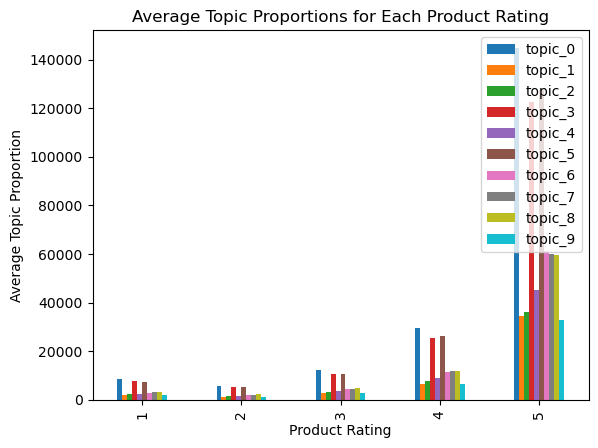

In [46]:
plt.figure(figsize=(10, 6))
topic_ratings.plot(kind='bar')
plt.xlabel('Product Rating')
plt.ylabel('Average Topic Proportion')
plt.title('Average Topic Proportions for Each Product Rating')
plt.legend(loc='upper right')
plt.show()